In [1]:
import numpy as np 
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

pd.options.display.float_format = '{:,.3f}'.format
pd.set_option('display.max_columns', 100)

import warnings
warnings.filterwarnings('ignore')


/Users/claudiacastro/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


# Recomendación. Campaña de email marketing.

# Objetivo

- Desarrollar una estrategia de email marketing dirigida a 10,000 clientes, priorizando los productos que generen mayor beneficio.



# Aspectos a tener en cuenta

1. Modelos de Predicción:

- Crear modelos predictivos para determinar qué productos tienen mayor probabilidad de ser contratados por cada cliente.
- Considerar no solo la probabilidad de contratación, sino también el beneficio económico de cada producto.
- Utilizar técnicas de modelado avanzadas como árboles de decisión, regresión logística y redes neuronales.
- Validar y evaluar los modelos utilizando métricas como la precisión, el recall y el AUC-ROC.
2. Selección de Clientes:
- Seleccionar los 10,000 clientes que recibirán los emails basados en los resultados del modelo predictivo.
- Justificar la elección de estos clientes y la estrategia empleada.

# Enfoques para la creación de los modelos predictivos

1. Creación de un modelo para cada producto:

- En este enfoque, se crearía un modelo predictivo separado para cada producto (por ejemplo, uno para short_term_deposit, otro para loans, otro para mortgage, etc.).

- Ventajas: Es específico para cada producto. El modelo se entrenaría específicamente para un producto, lo que permite que aprenda patrones únicos relacionados con la contratación de ese producto.
- Interpretabilidad: Los factores que influyen en la contratación de cada producto pueden ser más fáciles de interpretar.
- Desventajas: Sería costoso en términos de recursos ya que requiere entrenar y mantener múltiples modelos. Además, muchos de los modelos podrían utilizar características similares, lo que significa que se estaría trabajando doble.

2. Modelo agrupado por tipos de productos:

- Se agruparían los productos similares en categorías, exactamente como lo explicaba Erin (Responsable de Marketing Directo) en uno de sus correos [cuentas, productos de ahorro e inversión (planes, fondos, etc.) y financiación (préstamos y tarjetas)].

- Ventajas: Menos modelos que mantener en comparación con la opción de un modelo por producto. Además, se pueden identificar patrones que se aplican a categorías de productos.
- Desventajas: Puede que no capture detalles específicos de un solo producto tan bien como un modelo dedicado.

3. Modelo General para Todos los Productos:

- Se utilizaría un único modelo para predecir la probabilidad de que un cliente contrate cualquier producto.
- Ventajas: Es simple, solo hay que entrenar y mantener un único modelo, por tanto menos recursos computacionales y menos tiempo de entrenamiento.
- Desventajas: Puede ser más complejo interpretar las relaciones ya que el modelo tiene que captar información de todos los productos y si un producto es raro comparado con otros, el modelo puede no predecirlo correctamente.



# Procedimiento para la creación de los modelos predictivos.

Teniendo en cuenta lo anterior, a continuación se muestra el procedimiento a deasrrollar para resolver esta Tarea:

- Se trabajará a partir de un Modelo General Inicial que prediga la probabilidad de contratación de productos en general.


1. Preparación de Datos

- Se carga el dataset df_full_cleaned desde S3 de AWS
  
- Se crea la variable objetivo (compra): una columna binaria que indica si el cliente ha comprado algún producto (1) o no (0), independientemente del producto que sea, es decir, si al menos a comprado un producto es (1) si no es (0) .
- Se hace la partición de los datos en conjunto de entrenamiento (60%), validación(20%) y prueba(20%).
 
- El conjunto de validación se usa para evaluar el modelo durante todo el proceso de ajuste, desde la Iteración 1 hasta la 3, permitiendo ver cómo el modelo generaliza a datos que no ha visto durante el entrenamiento.

- En la última etapa se selecciona el mejor modelo y se hace un ajuste de hiperparámetros, para luego hacer una evaluación final con el conjunto de prueba para obtener una medida objetiva de la capacidad del modelo para generalizar a datos completamente nuevos.



2. Iteración 1: Modelos Iniciales. Para el entrenamiento se van a tener en cuenta los siguientes modelos:

- Regresión Logística
- Random Forest
- XGBoost
- K-Nearest Neighbors (KNN)
- Support Vector Machine (SVM)

- Se usará accuracy, precision, recall, F1-score para evaluar el rendimiento de cada modelo en el conjunto de validación y se analiza el comportamiento de los modelos, así como la importancia de las características. 

- Se realiza un análisis de correlación de las variables numéricas eliminando las que presenten una alta correlacción (> 90%).

3. Iteración 2: Feature Engineering

- Se crean nuevas características, generando interacciones o combinaciones de variables, teneindo en cuenta las caracteristicas más relevantes en la Iteración 1.

- Entrenar y evaluar los mismos modelos que en la iteración 1, con las nuevas características.

4. Iteración 3: Refinamiento del Modelo

- Análisis de las características menos relevantes según su importancia en los modelos anteriores.

- Se vuelven a entrenar los modelos, se evaluan y se comparan los resultados.

5. Selección del modelo y ajuste de hiperparámetros

- A partir del modelo que mejor comportamiento presente se realiza un ajuste de hiperparámetros usando GridSearchCV. 
 
- Se evalua el rendimiento final del modelo ajustado tanto en el conjunto de validación como de test.







---

## Preparación de datos.

In [2]:
# cargando el dataset completo directamente desde S3 de AWS

df_full = pd.read_parquet("https://easy-money-project-bucket.s3.eu-west-3.amazonaws.com/df_full_cleaned.parquet")
df_full

,pk_cid,pk_partition,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,em_account_pp,credit_card,payroll,pension_plan,payroll_account,emc_account,debit_card,em_account_p,em_acount,num_products_contracts,p_cuenta_bancaria,cuentas_sum,p_inversion,inversion_sum,p_financiacion,financiacion_sum,profit_cuentas,profit_inversion,profit_financiacion,country_id,gender,mes_partition,mes_nombre_partition,grupo_edad,median_salary,region_code,entry_date,entry_channel,active_customer,segment,categoria_antiguedad
0,1375586,2018-01-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,10,0,0,ES,H,1,January,Adultos jóvenes,"87,218.100",Málaga,2018-01-12,Otros,1,02 - PARTICULARES,1-2 años
1,1050611,2018-01-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,10,0,0,ES,V,1,January,Jóvenes,"35,548.740",Ciudad Real,2015-08-10,KHE,0,03 - UNIVERSITARIO,Más de 3 años
2,1050612,2018-01-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,10,0,0,ES,V,1,January,Jóvenes,"122,179.110",Ciudad Real,2015-08-10,KHE,0,03 - UNIVERSITARIO,Más de 3 años
3,1050613,2018-01-28,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,40,0,ES,H,1,January,Jóvenes,"119,775.540",Zaragoza,2015-08-10,KHD,0,03 - UNIVERSITARIO,Más de 3 años
4,1050614,2018-01-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,10,0,0,ES,V,1,January,Jóvenes,"101,469.135",Zaragoza,2015-08-10,KHE,1,03 - UNIVERSITARIO,Más de 3 años
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5962919,1166765,2019-05-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,10,0,0,ES,V,5,May,Jóvenes,"43,912.170",Zaragoza,2016-08-14,KHE,0,03 - UNIVERSITARIO,2-3 años
5962920,1166764,2019-05-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,10,0,0,ES,V,5,May,Jóvenes,"23,334.990","Rioja, La",2016-08-14,KHE,0,03 - UNIVERSITARIO,2-3 años
5962921,1166763,2019-05-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,10,0,0,ES,H,5,May,Adultos,"87,930.930",Zaragoza,2016-08-14,KHE,1,02 - PARTICULARES,2-3 años
5962922,1166789,2019-05-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,10,0,0,ES,H,5,May,Jóvenes,"199,592.820",Zaragoza,2016-08-14,KHE,0,03 - UNIVERSITARIO,2-3 años


In [3]:
# se agrupa los productos por cliente y se calcula la media de los productos
# lo cual indica la actividad de cada cliente en cada producto

lista_productos = ["pk_cid","short_term_deposit", "loans", "mortgage", "funds", "securities", 
                   "long_term_deposit", "credit_card", "payroll_account", 
                   "emc_account", "debit_card", "em_acount", "payroll", "pension_plan"]

df_productos = df_full[lista_productos].groupby("pk_cid").mean()
df_productos


,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,credit_card,payroll_account,emc_account,debit_card,em_acount,payroll,pension_plan
pk_cid,,,,,,,,,,,,,
15891,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.500,0.000,0.000
16063,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
16203,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.833,0.000,0.000
16502,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.556,0.000,0.889,0.000,0.000
17457,0.000,0.000,0.000,0.000,0.000,0.941,0.000,0.000,0.000,0.294,1.000,0.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1553685,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
1553686,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
1553687,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


In [4]:
# columnas a utilizar sacadas del dataset completo que se van a utilizar para el modelo


columnas_relevantes = ["pk_cid","country_id"	,"gender", "median_salary",	"region_code",	
                       "entry_date","entry_channel"	,"active_customer",	"segment",	"categoria_antiguedad", "num_products_contracts"]

# se agrupa el dataset por las columnas relevantes por cliente y se toma la última fila de cada cliente
# ya estas columnas vienen limpias y listas para ser utilizadas en el modelo de la tarea anterior
df_relevantes = df_full[columnas_relevantes].groupby("pk_cid").last()

In [5]:
# se importa el dataset de sociodemográfico que se limpió en la tarea anterior
# para obtener la edad de cada cliente y trabajar con ella en el modelo
sociod = pd.read_parquet('https://easy-money-project-bucket.s3.eu-west-3.amazonaws.com/sociodemographic_df.parquet')
edad = sociod.groupby("pk_cid").last()

In [6]:
# se unen los datasets de productos y relevantes para tener un dataset completo
# con todas las columnas necesarias para el modelo
df_fulll = df_productos.merge(df_relevantes, on = "pk_cid")
df_fulll = df_fulll.merge(edad["age"], on = "pk_cid")
df_fulll

,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,credit_card,payroll_account,emc_account,debit_card,em_acount,payroll,pension_plan,country_id,gender,median_salary,region_code,entry_date,entry_channel,active_customer,segment,categoria_antiguedad,num_products_contracts,age
pk_cid,,,,,,,,,,,,,,,,,,,,,,,,
15891,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.500,0.000,0.000,ES,H,"117,380.925",Madrid,2018-07-28,KAT,0,02 - PARTICULARES,0-3 meses,0,59
16063,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,ES,H,"132,384.450",Madrid,2018-11-19,KAT,0,02 - PARTICULARES,6-9 meses,0,62
16203,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.833,0.000,0.000,ES,V,"153,902.880",Barcelona,2018-12-23,KAT,1,01 - TOP,3-6 meses,1,70
16502,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.556,0.000,0.889,0.000,0.000,ES,H,"132,384.450",Madrid,2018-09-30,KHN,1,02 - PARTICULARES,6-9 meses,2,58
17457,0.000,0.000,0.000,0.000,0.000,0.941,0.000,0.000,0.000,0.294,1.000,0.000,0.000,ES,H,"102,405.750",Madrid,2017-09-16,KAT,1,02 - PARTICULARES,1-2 años,3,54
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1553685,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,ES,V,"114,633.765",Ciudad Real,2019-05-31,Otros,0,03 - UNIVERSITARIO,0-3 meses,0,52
1553686,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,ES,H,"85,787.220",Sevilla,2019-05-31,Otros,0,03 - UNIVERSITARIO,0-3 meses,0,30
1553687,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,ES,V,"143,419.770",Madrid,2019-05-31,Otros,0,03 - UNIVERSITARIO,0-3 meses,0,21


Otras transformaciones necesarias para el modelo

In [7]:
# se reemplazan los valores en region_code por la frecuencia de cada provincia
# Paso 1: Calcular la frecuencia de cada provincia
frecuencias_provincia = df_fulll['region_code'].value_counts(normalize=True)  # normalize=True para obtener las frecuencias relativas
# Paso 2: Mapear las frecuencias a la columna de provincia
df_fulll['region_code'] = df_fulll['region_code'].map(frecuencias_provincia)

#lo mismo que el paso anterior pero con entry_channel
frecuencias_entry_channel = df_fulll['entry_channel'].value_counts(normalize=True) 
df_fulll['entry_channel'] = df_fulll['entry_channel'].map(frecuencias_entry_channel)

In [8]:
# Se lleva df_fulll["entry_date"] a formato numerico
df_fulll["entry_date"] = df_fulll["entry_date"].apply(lambda x: x.toordinal())

In [9]:
#df_fulll["country_id"].value_counts("ES" , normalize = True)
# quiero saber cuantos no son ES
df_fulll["country_id"] = df_fulll["country_id"].apply(lambda x: 1 if x == "ES" else 0)
df_fulll["country_id"].value_counts()


country_id
1    456209
0       164
Name: count, dtype: int64

Como solo 164 clientes son extranjeros, es decir, no son "ES", se va a eliminar esa columna, no aporta suficiente información.

In [10]:
df_fulll.drop("country_id", axis = 1, inplace = True)
df_fulll

,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,credit_card,payroll_account,emc_account,debit_card,em_acount,payroll,pension_plan,gender,median_salary,region_code,entry_date,entry_channel,active_customer,segment,categoria_antiguedad,num_products_contracts,age
pk_cid,,,,,,,,,,,,,,,,,,,,,,,
15891,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.500,0.000,0.000,H,"117,380.925",0.215,736903,0.059,0,02 - PARTICULARES,0-3 meses,0,59
16063,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,H,"132,384.450",0.215,737017,0.059,0,02 - PARTICULARES,6-9 meses,0,62
16203,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.833,0.000,0.000,V,"153,902.880",0.101,737051,0.059,1,01 - TOP,3-6 meses,1,70
16502,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.556,0.000,0.889,0.000,0.000,H,"132,384.450",0.215,736967,0.037,1,02 - PARTICULARES,6-9 meses,2,58
17457,0.000,0.000,0.000,0.000,0.000,0.941,0.000,0.000,0.000,0.294,1.000,0.000,0.000,H,"102,405.750",0.215,736588,0.059,1,02 - PARTICULARES,1-2 años,3,54
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1553685,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,V,"114,633.765",0.011,737210,0.035,0,03 - UNIVERSITARIO,0-3 meses,0,52
1553686,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,H,"85,787.220",0.047,737210,0.035,0,03 - UNIVERSITARIO,0-3 meses,0,30
1553687,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,V,"143,419.770",0.215,737210,0.035,0,03 - UNIVERSITARIO,0-3 meses,0,21


In [13]:
# transformación de variables objects a categóricas
df_fulll["gender"] = df_fulll["gender"].astype("category")
df_fulll["region_code"] = df_fulll["region_code"].astype("category")  
df_fulll["entry_channel"] = df_fulll["entry_channel"].astype("category")

Ya por último, creamos la variable objetivo, la que vamos a predecir

In [11]:
# IMPORTANTE
# Se Crea la variable objetivo
# Se crea una variable objetivo que indica si el cliente ha comprado algún producto o no

df_fulll["compra"] = df_fulll["num_products_contracts"].apply(lambda x: 1 if x > 0 else 0)

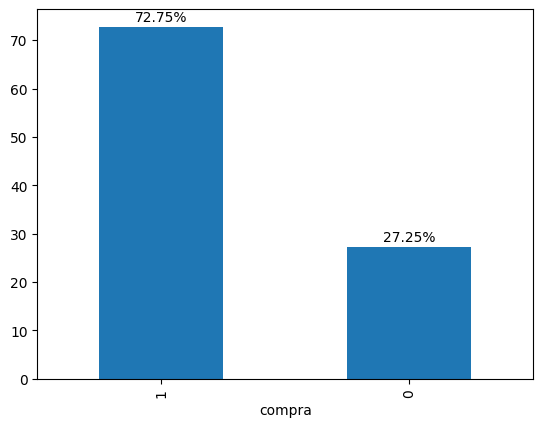

In [12]:
# Comportamiento de la variable objetivo

(df_fulll["compra"].value_counts(normalize=True)*100).plot(kind="bar")
for i, v in enumerate(df_fulll["compra"].value_counts(normalize=True)*100):
    plt.text(i, v + 0.5, str(round(v, 2)) + "%", ha='center', va='bottom')

Se observa que la variable objetivo está un poco desbalanceada, lo cual se tendré en cuenta a la hora de trabajar.

---

### 1. Iteración 1 (baseline).

División de los conjuntos, selección de columnas numericas y categóricas y analisis de correlación de las numéricas.

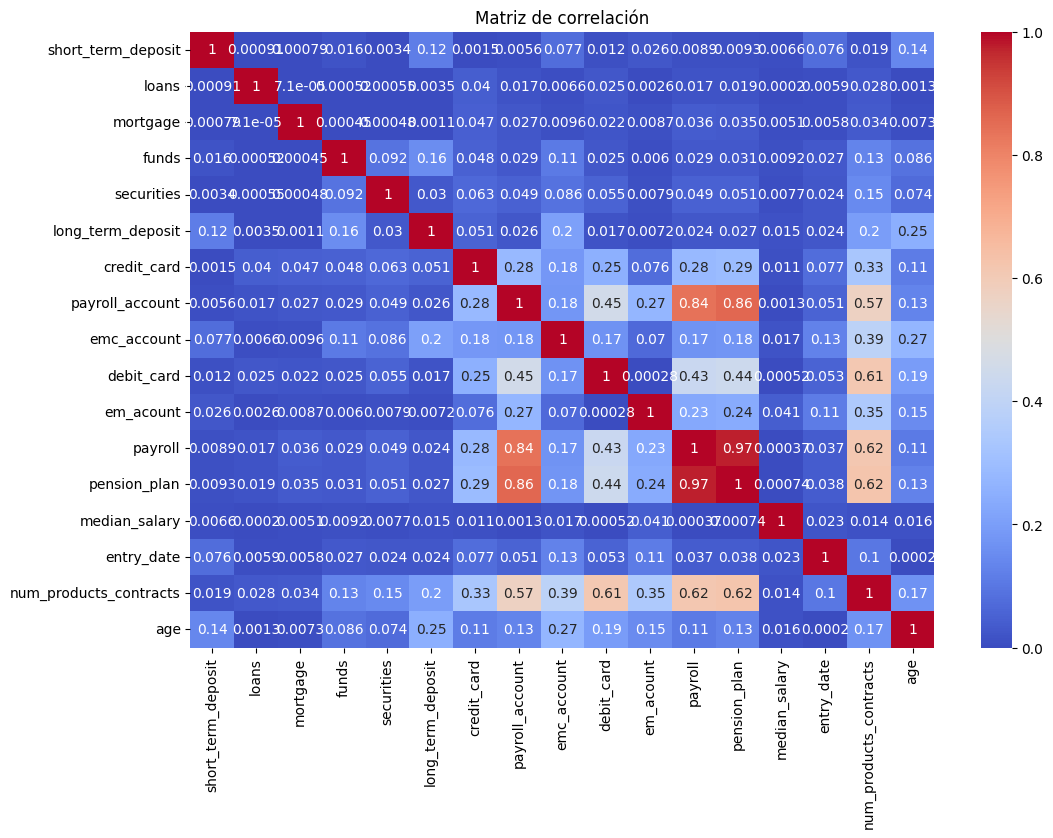

Columnas que no pasan al siguiente análisis debido a alta correlación: ['pension_plan']


In [14]:


# 1. Cargar el dataset
X_full = df_fulll.copy()

y = X_full['compra']  # Variable objetivo
X_full.drop(['compra'], axis=1, inplace=True)

# 4. Dividir los datos en entrenamiento (60%), validación (20%) y test (20%)
# El 60% de los datos originales se asigna al conjunto de entrenamiento (X_train_full y y_train).
# El 40% restante se divide en dos partes iguales: el 20% para el conjunto de validación (X_valid_full y y_valid) 
# y el 20% para el conjunto de prueba (X_test_full y y_test).
X_train_full, X_temp, y_train, y_temp = train_test_split(X_full, y, train_size=0.6, test_size=0.4, random_state=11, stratify=y)
X_valid_full, X_test_full, y_valid, y_test = train_test_split(X_temp, y_temp, train_size=0.5, test_size=0.5, random_state=11, stratify=y_temp)

# 5. Seleccionar columnas categóricas y numéricas
categorical_cols = [cname for cname in X_train_full.columns if X_train_full[cname].dtype == "category"]
numerical_cols = [cname for cname in X_train_full.columns if X_train_full[cname].dtype in ['int64', 'float64']]
my_cols = categorical_cols + numerical_cols 
X_train = X_train_full[my_cols].copy()
X_valid = X_valid_full[my_cols].copy()
X_test = X_test_full[my_cols].copy()
    
#---------------------------------------------------------

# 1. Calcular la matriz de correlación para las columnas numéricas
correlation_matrix = X_train[numerical_cols].corr().abs()

# 2. Visualizar la matriz de correlación como un mapa de calor
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=0, vmax=1)
plt.title("Matriz de correlación")
plt.show()

# 3. Identificar columnas con correlación mayor a 0.90
upper_tri = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))

# Encuentra las columnas que tienen correlación > 0.90
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.90)]

# 4. Eliminar columnas con alta correlación en el conjunto de entrenamiento
X_train = X_train.drop(columns=to_drop)
X_valid = X_valid.drop(columns=to_drop)
X_test = X_test.drop(columns=to_drop)

# Mostrar columnas eliminadas
print("Columnas que no pasan al siguiente análisis debido a alta correlación:", to_drop)

#---------------------------------------------------------



Definición del preprocesamiento, definición de los modelos, entrenamiento y evaluación de cada uno de los modelos seleccionados.

NOTA: por tiempos de ejecución muy elevados, se va a trabajar con 3 de los 5 modelos seleccionados.

In [16]:

    
# 6. Preprocesamiento de los datos
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', Pipeline(steps=[
            ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'))
        ]), categorical_cols)
    ]
)

# 7. Definir modelos a evaluar
models = {
    'RandomForest': RandomForestClassifier( random_state=11, n_jobs=-1),
    "LogisticRegression": LogisticRegression( random_state=11, n_jobs=-1),
    "XGBClassifier": XGBClassifier( random_state=11, n_jobs=-1),
    # "KNN": KNeighborsClassifier( n_jobs=-1),
    # "SVM": SVC( random_state=11),

    
}

# 8. Entrenar y evaluar cada modelo
tabla_metricas = pd.DataFrame(columns=['Modelo', "accuracy", "roc_auc", "f1_score", "precision", "recall"])

for name, model in models.items():
    clf = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])
    # 6. Crear el pipeline completo, incluyendo el eliminador de correlación
    clf.fit(X_train, y_train)
    
    y_pred = clf.predict(X_valid)
    y_pred_proba = clf.predict_proba(X_valid)[:, 1]
    
    accuracy = accuracy_score(y_valid, y_pred)
    roc_auc = roc_auc_score(y_valid, y_pred_proba)
    f1 = f1_score(y_valid, y_pred)  # Cambié el nombre de la variable
    precision = precision_score(y_valid, y_pred)
    recall = recall_score(y_valid, y_pred)
    
    new_row = pd.DataFrame({'Modelo': [name], 'accuracy': [accuracy], 
                            'roc_auc': [roc_auc], 'f1_score': [f1],  # Cambié el nombre de la variable
                            'precision': [precision], 'recall': [recall]})
    tabla_metricas = pd.concat([tabla_metricas, new_row], ignore_index=True)
    

# 11. Mostrar las métricas
print("Tabla de métricas:")
print(tabla_metricas)

Tabla de métricas:
               Modelo  accuracy  roc_auc  f1_score  precision  recall
0        RandomForest     0.764    0.749     0.852      0.784   0.932
1  LogisticRegression     0.734    0.714     0.838      0.751   0.949
2       XGBClassifier     0.767    0.756     0.855      0.781   0.944


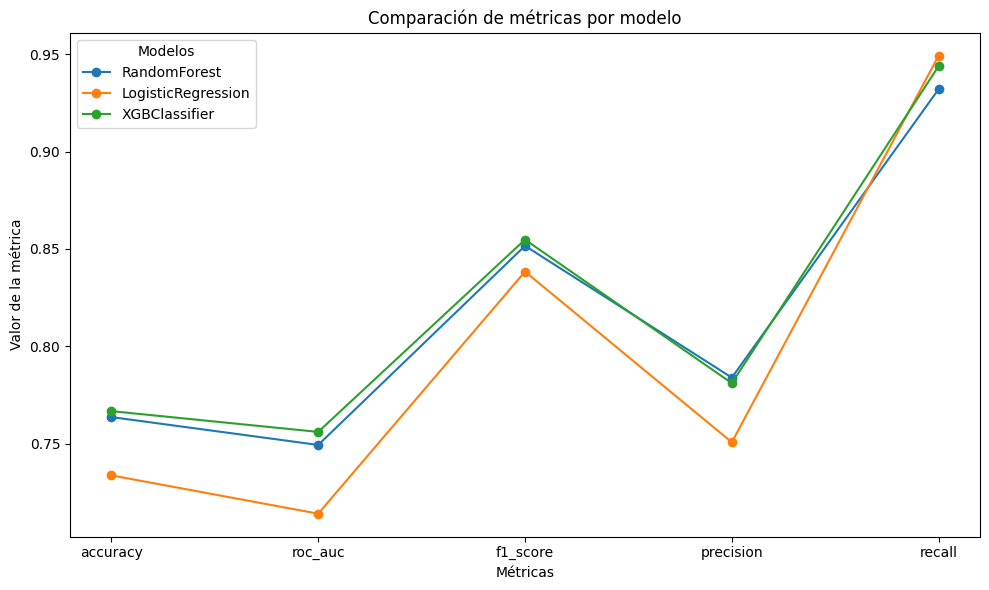

In [28]:
# Establecer el tamaño del gráfico
plt.figure(figsize=(10, 6))

# Definir las métricas que se usarán como etiquetas en el eje X
metricas = ['accuracy', 'roc_auc', 'f1_score', 'precision', 'recall']

# Graficar una línea por cada modelo
for modelo in tabla_metricas['Modelo']:
    plt.plot(metricas, tabla_metricas[tabla_metricas['Modelo'] == modelo].iloc[0, 1:], marker='o', label=modelo)

# Añadir etiquetas y título
plt.xlabel('Métricas')
plt.ylabel('Valor de la métrica')
plt.title('Comparación de métricas por modelo')
plt.legend(title='Modelos')

# Mostrar el gráfico
plt.tight_layout()
plt.show()

Hasta el momento:

- XGBClassifier es el modelo con mejor comportamiento y de mejor rendimiento general, ya que tiene valores altos en todas las métricas importantes, especialmente en accuracy y roc_auc.
 
- RandomForest también es competitivo y muy cercano en varias métricas.
 
- LogisticRegression tiene un rendimiento peor en la mayoría de las métricas, excepto en recall, donde se destaca.

### 2. Iteración 2.